# Imports, Custom Functions & Data Loading

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import spacy 

from collections import Counter, defaultdict
from transformers import AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

# spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

## Define functions

In [2]:
def read_csv(filename):
    return pd.read_csv(filename, sep=',', encoding='utf-8', index_col=0).iloc[:, -2:].reset_index(drop=True)


def preprocess(text):
    
    # remove URLs
    text = re.sub('http\S*', ' ', text)
    
    # remove non-alphabetic
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # make lowercase
    text = text.lower()

    # remove one character word
    text = re.sub("\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub("^[a-zA-Z]\s+", '', text)
    
    # replace double space to one space
    text = re.sub("\s+", ' ', text)
    
    # tokenize, lemmatize, remove stop words
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(text)


class BPE():
    """Byte-Pair Encoding: Subword-based tokenization algorithm."""
    
    def __init__(self, corpus, vocab_size):
        """Initialize BPE tokenizer."""
        self.corpus = corpus
        self.vocab_size = vocab_size
        
        # pre-tokenize the corpus into words, BERT pre-tokenizer is used here
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.word_freqs = defaultdict(int)
        self.splits = {}
        self.merges = {}
    
    
    def train(self):
        """Train BPE tokenizer."""

        # compute the frequencies of each word in the corpus
        for text in self.corpus:
            words_with_offsets = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        # compute the base vocabulary of all characters in the corpus
        alphabet = []
        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()

        # add the special token </w> at the beginning of the vocabulary
        vocab = ["</w>"] + alphabet.copy()

        # split each word into individual characters before training
        self.splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        # merge the most frequent pair iteratively until the vocabulary size is reached
        while len(vocab) < self.vocab_size:

            # compute the frequency of each pair
            pair_freqs = self.compute_pair_freqs()

            # find the most frequent pair
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq

            # merge the most frequent pair
            self.splits = self.merge_pair(*best_pair)
            self.merges[best_pair] = best_pair[0] + best_pair[1]
            vocab.append(best_pair[0] + best_pair[1])
        return self.merges


    def compute_pair_freqs(self):
        """Compute the frequency of each pair."""

        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = self.splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs


    def merge_pair(self, a, b):
        """Merge the given pair."""

        for word in self.word_freqs:
            split = self.splits[word]
            if len(split) == 1:
                continue
            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            self.splits[word] = split
        return self.splits
    

    def tokenize(self, text):
        """Tokenize a given text with trained BPE tokenizer (including pre-tokenization, split, and merge)."""
        
        pre_tokenize_result = self.tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        splits_text = [[l for l in word] for word in pre_tokenized_text]

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits_text):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits_text[idx] = split
        result = sum(splits_text, [])
        return result
    

def get_tfidf_matrix(df, vectorizer):
    
    # Convert the TF-IDF matrix to a dense NumPy array
    matrix = df.todense()

    # Convert the dense matrix to a DataFrame
    matrix = pd.DataFrame(matrix, columns=vectorizer.get_feature_names_out())

    return matrix


# Function to get the embedding for all tokens from a list of tokens
def get_embeddings(tokens, model):
    embeddings = []
    for token in tokens:
        try:
            embeddings.append(model.wv[token])
        except:
            pass
    return np.array(embeddings)


def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0, perplexity = 10)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

## Data Loading

In [3]:
tweets_train = read_csv('../data/tweets_data/train.csv')
tweets_test = read_csv('../data/tweets_data/test.csv')[['text']]

print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Testing data


,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


# Text pre-processing

## Cleaning text using key-words and lemmatization

In [4]:
tweets_train['clean_text'] = tweets_train['text'].apply(preprocess)
tweets_test['clean_text'] = tweets_test['text'].apply(preprocess)

In [5]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...



Testing data


,text,clean_text
0,Just happened a terrible car crash,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


## Sub-word tokenization with BERT Tokenizer for Byte-Pair Encoding 

In [6]:
# set the hyperparameter of vocabulary size
vocab_size = 3000
corpus = tweets_train['clean_text'].tolist()

# create a BPE tokenizer object
MyBPE = BPE(corpus=corpus, vocab_size=vocab_size)

# train BPE tokenizer with Wikipedia corpus
MyBPE.train()

{('e', 'r'): 'er',
 ('r', 'e'): 're',
 ('i', 'n'): 'in',
 ('a', 'n'): 'an',
 ('o', 'n'): 'on',
 ('s', 't'): 'st',
 ('a', 't'): 'at',
 ('a', 'r'): 'ar',
 ('a', 'l'): 'al',
 ('o', 'r'): 'or',
 ('e', 'n'): 'en',
 ('l', 'e'): 'le',
 ('l', 'i'): 'li',
 ('d', 'e'): 'de',
 ('i', 'c'): 'ic',
 ('s', 'e'): 'se',
 ('a', 'm'): 'am',
 ('r', 'o'): 'ro',
 ('l', 'o'): 'lo',
 ('i', 'l'): 'il',
 ('a', 'c'): 'ac',
 ('i', 't'): 'it',
 ('s', 'h'): 'sh',
 ('u', 'n'): 'un',
 ('c', 'h'): 'ch',
 ('c', 'o'): 'co',
 ('u', 'r'): 'ur',
 ('v', 'e'): 've',
 ('t', 'h'): 'th',
 ('r', 'a'): 'ra',
 ('i', 'on'): 'ion',
 ('g', 'e'): 'ge',
 ('i', 's'): 'is',
 ('m', 'e'): 'me',
 ('in', 'g'): 'ing',
 ('a', 'y'): 'ay',
 ('k', 'e'): 'ke',
 ('n', 'e'): 'ne',
 ('a', 'd'): 'ad',
 ('r', 'i'): 'ri',
 ('h', 'o'): 'ho',
 ('o', 'd'): 'od',
 ('s', 's'): 'ss',
 ('at', 'e'): 'ate',
 ('en', 't'): 'ent',
 ('e', 'l'): 'el',
 ('a', 'p'): 'ap',
 ('f', 'i'): 'fi',
 ('l', 'y'): 'ly',
 ('t', 'er'): 'ter',
 ('o', 'm'): 'om',
 ('g', 'h'): 'gh',
 (

In [7]:
# Tokennize the training and testing data
tweets_train['tokenized_text'] = tweets_train['clean_text'].apply(MyBPE.tokenize)
tweets_test['tokenized_text'] = tweets_test['clean_text'].apply(MyBPE.tokenize)

In [8]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild..."



Testing data


,text,clean_text,tokenized_text
0,Just happened a terrible car crash,happen terrible car crash,"[happen, ter, rible, car, crash]"
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]"
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ..."
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]"
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]"


## Convert Text into Input Features

### TF-IDF

In [9]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(tweets_train['tokenized_text'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_train['TFIDF'] = X_train.toarray().tolist()

X_test = vectorizer.transform(tweets_test['tokenized_text'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_test['TFIDF'] = X_test.toarray().tolist()

In [10]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text,TFIDF
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Testing data


,text,clean_text,tokenized_text,TFIDF
0,Just happened a terrible car crash,happen terrible car crash,"[happen, ter, rible, car, crash]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Word2Vec (CBOW and Skip-Gram)

In [11]:
# Train Word2Vec model
cbow_model = Word2Vec(sentences = tweets_train['tokenized_text'], vector_size = 1024, window = 10, min_count = 1, workers = 4, sg = 0, epochs = 1024)
skipgram_model = Word2Vec(sentences = tweets_train['tokenized_text'], vector_size = 1024, window = 10, min_count = 1, workers = 4, sg = 1, epochs = 1024)

# Apply the get_embedding function to create a new column 'Embedding'
tweets_train['CBOW'] = tweets_train['tokenized_text'].apply(lambda tokens: get_embeddings(tokens, cbow_model))
tweets_train['SkipGram'] = tweets_train['tokenized_text'].apply(lambda tokens: get_embeddings(tokens, skipgram_model))

tweets_test['CBOW'] = tweets_test['tokenized_text'].apply(lambda tokens: get_embeddings(tokens, cbow_model))
tweets_test['SkipGram'] = tweets_test['tokenized_text'].apply(lambda tokens: get_embeddings(tokens, skipgram_model))

In [12]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text,TFIDF,CBOW,SkipGram
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-1.6314894, -1.0553808, 0.5692053, -0.497278...","[[-0.1806214, -0.13585225, 0.045525506, 0.0486..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.376651, 5.2282586, -1.0635961, 0.46587625...","[[-0.8313005, -0.039876133, -0.08258973, 0.093..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.24069177, -0.40758923, -0.5841669, -0.0185...","[[-0.90858287, 0.021392953, -0.29578468, 0.445..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-1.1186098, -0.79676974, 0.81508327, -0.4273...","[[-0.15906572, -0.025815988, 0.4092848, 0.0004..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[got, send, photo, ru, by, alaska, smoke, wild...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-1.8993948, 0.2242292, -1.169199, -1.461699,...","[[-0.2337436, 0.16917074, 0.5111954, -0.279146..."



Testing data


,text,clean_text,tokenized_text,TFIDF,CBOW,SkipGram
0,Just happened a terrible car crash,happen terrible car crash,"[happen, ter, rible, car, crash]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.22261816, -1.7385163, -1.5693245, -0.05720...","[[-0.0852688, -0.21742979, -0.24319029, 0.0737..."
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.066372916, 0.2503301, -0.61496925, -0.073...","[[-0.07943516, -0.033563837, 0.058746208, 0.28..."
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.376651, 5.2282586, -1.0635961, 0.46587625...","[[-0.8313005, -0.039876133, -0.08258973, 0.093..."
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8659962, 0.0022255096, 0.2605529, -2.26580...","[[0.12737215, -0.21916558, 0.05195798, -0.3334..."
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.2547363, -0.8706169, 0.2554416, 0.7669557,...","[[-0.26170215, -0.22853695, -0.04341958, -0.04..."


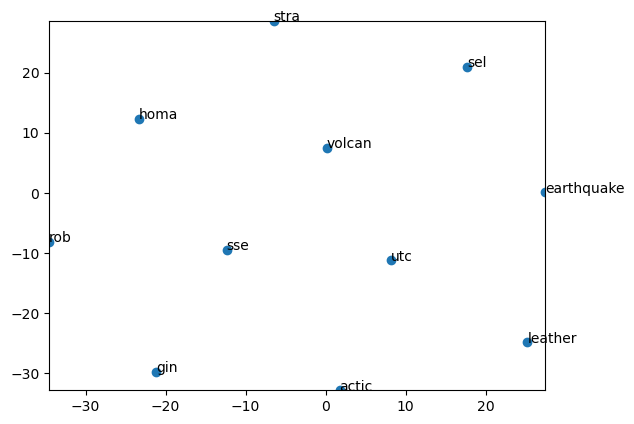

In [13]:
display_closestwords_tsnescatterplot(cbow_model, 'earthquake', 1024)

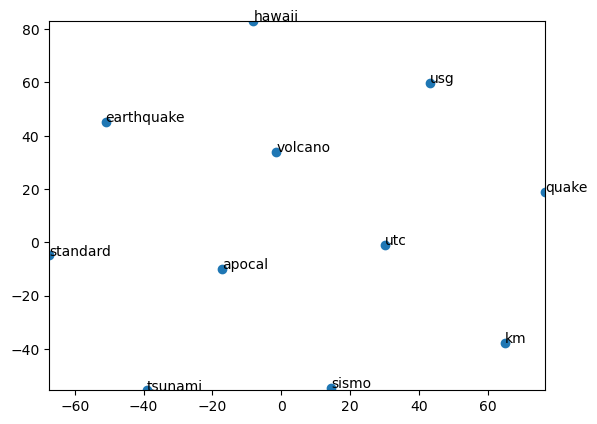

In [14]:
display_closestwords_tsnescatterplot(skipgram_model, 'earthquake', 1024)

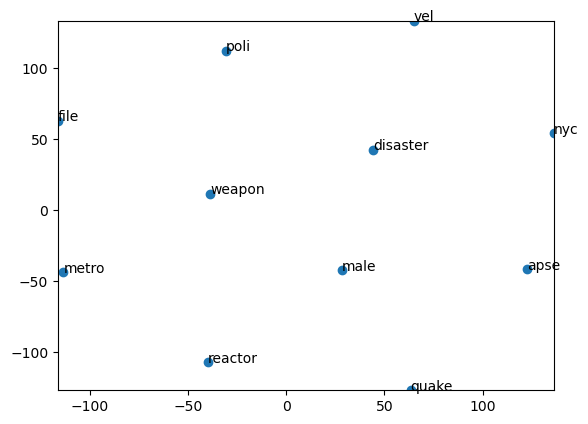

In [15]:
display_closestwords_tsnescatterplot(cbow_model, 'disaster', 1024)

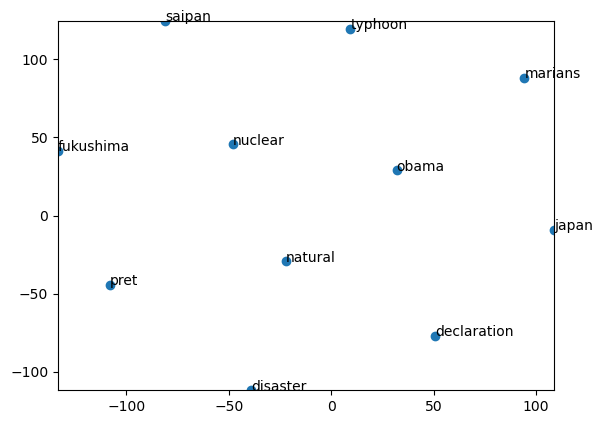

In [16]:
display_closestwords_tsnescatterplot(skipgram_model, 'disaster', 1024)